<div class="alert alert-block alert-success">
    <h1 align="center">Machine Learning in Python</h1>
    <h3 align="center">Mini Project2 - Bike Sharing</h3>
</div>

<img src = "https://storage.googleapis.com/kaggle-competitions/kaggle/3948/media/bikes.png" width=80%>

<div class="alert alert-block alert-info">
    <h2 align="center">Importing the libraries</h2>
</div>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import calendar
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

<div class="alert alert-block alert-info">
    <h2 align="center">Load and Prepare Data</h2>
</div>

In [2]:
data_train = pd.read_csv('train.csv')
data_train

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129


In [3]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [4]:
data_train.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

<div class="alert alert-block alert-warning">
    <h4 align="center">Converting datetime into a usable format</h4>
</div>

In [5]:
data_train["date"] = data_train.datetime.apply(lambda x : x.split()[0])
data_train["hour"] = data_train.datetime.apply(lambda x : x.split()[1].split(":")[0])
data_train["weekday"] = data_train.date.apply(lambda dateString : calendar.day_name[datetime.strptime(dateString,"%Y-%m-%d").weekday()])
data_train["month"] = data_train.date.apply(lambda dateString : calendar.month_name[datetime.strptime(dateString,"%Y-%m-%d").month])

<div class="alert alert-block alert-warning">
    <h4 align="center">Labeling categorical data</h4>
</div>

In [6]:
data_train["season"] = data_train.season.map({1: "Spring", 2 : "Summer", 3 : "Fall", 4 :"Winter" })
data_train["weather"] = data_train.weather.map({1: " Clear + Few clouds + Partly cloudy + Partly cloudy",\
                                        2 : " Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist ", \
                                        3 : " Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds", \
                                        4 :" Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog " })

<div class="alert alert-block alert-info">
    <h2 align="center">EDA</h2>
</div>

<div class="alert alert-block alert-warning">
    <h4 align="center">Rental count has normal distribution across all seasons except spring</h4>
</div>

In [7]:
data_train.groupby('season')[['casual' , 'registered' ,'count']].sum()

,casual,registered,count
season,,,
Fall,142718,497944,640662
Spring,41605,270893,312498
Summer,129672,458610,588282
Winter,78140,465894,544034


<div class="alert alert-block alert-warning">
    <h4 align="center">Given that holidays are less frequent, rental count is also extremely lower on holidays</h4>
</div>

In [8]:
data_train.groupby('holiday')[['casual' , 'registered' ,'count']].sum()

,casual,registered,count
holiday,,,
0,376964,1650704,2027668
1,15171,42637,57808


<div class="alert alert-block alert-warning">
    <h4 align="center">Rental count is doubled in working day comparing to any other day (weekends and holidays)</h4>
</div>

In [9]:
data_train.groupby('workingday')[['casual' , 'registered' ,'count']].sum()

,casual,registered,count
workingday,,,
0,206037,448835,654872
1,186098,1244506,1430604


In [10]:
pd.crosstab(data_train['season'] , data_train['workingday'])

workingday,0,1
season,,
Fall,888,1845
Spring,858,1828
Summer,840,1893
Winter,888,1846


<div class="alert alert-block alert-warning">
    <h4 align="center">Weather condition has the most extreme effect on rental count</h4>
</div>

In [11]:
data_train.groupby('weather')[['casual' , 'registered' ,'count']].sum()

,casual,registered,count
weather,,,
Clear + Few clouds + Partly cloudy + Partly cloudy,289900,1186163,1476063
"Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog",6,158,164
"Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds",14983,87106,102089
"Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist",87246,419914,507160


<div class="alert alert-block alert-warning">
    <h4 align="center">Considering that only spring has weather type 4 and the much lower temperature on weather type 4,
                       it make sense that spring has lower rental count</h4>
</div>

In [12]:
data_train.groupby('season')[['temp']].mean()

,temp
season,
Fall,28.789111
Spring,12.530491
Summer,22.823483
Winter,16.649239


In [13]:
data_train.groupby('weather')[['temp']].mean()

,temp
weather,
Clear + Few clouds + Partly cloudy + Partly cloudy,20.557122
"Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog",8.200000
"Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds",19.546356
"Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist",19.614608


In [14]:
data_train.groupby(['season' , 'weather'])[['temp']].mean()

temp
season weather                                                      
Fall    Clear + Few clouds + Partly cloudy + Partly cl...  29.227264
        Light Snow, Light Rain + Thunderstorm + Scatte...  26.788040
        Mist + Cloudy, Mist + Broken clouds, Mist + Fe...  28.048344
Spring  Clear + Few clouds + Partly cloudy + Partly cl...  12.539147
        Heavy Rain + Ice Pallets + Thunderstorm + Mist...   8.200000
        Light Snow, Light Rain + Thunderstorm + Scatte...  12.152322
        Mist + Cloudy, Mist + Broken clouds, Mist + Fe...  12.626853
Summer  Clear + Few clouds + Partly cloudy + Partly cl...  23.180822
        Light Snow, Light Rain + Thunderstorm + Scatte...  21.001518
        Mist + Cloudy, Mist + Broken clouds, Mist + Fe...  22.490932
Winter  Clear + Few clouds + Partly cloudy + Partly cl...  16.235711
        Light Snow, Light Rain + Thunderstorm + Scatte...  18.626756
        Mist + Cloudy, Mist + Broken clouds, Mist + Fe...  16.970037

<div class="alert alert-block alert-warning">
    <h4 align="center">There is 3 to 4 degree diffrence between real temperature and the temperature felt across all seasons                          and weather types</h4>
</div>

In [15]:
data_train.groupby('weather')[['temp' , 'atemp', 'humidity' , 'windspeed']].mean()

,temp,atemp,humidity,windspeed
weather,,,,
Clear + Few clouds + Partly cloudy + Partly cloudy,20.557122,23.994126,56.716769,12.892542
"Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog",8.200000,11.365000,86.000000,6.003200
"Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds",19.546356,22.753091,81.341094,14.071248
"Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist",19.614608,23.072414,69.100565,12.179905


In [16]:
data_train.groupby('season')[['temp' , 'atemp' , 'humidity' , 'windspeed']].mean()

,temp,atemp,humidity,windspeed
season,,,,
Fall,28.789111,32.540783,64.123674,11.508862
Spring,12.530491,15.228956,56.297841,14.636978
Summer,22.823483,26.647098,60.852909,13.405607
Winter,16.649239,20.059909,66.173738,11.678147


<div class="alert alert-block alert-info">
    <h2 align="center">Strorytelling - Visualization</h2>
</div>

<div class="alert alert-block alert-warning">
    <h4 align="center">Distribuation of rental count</h4>
</div>

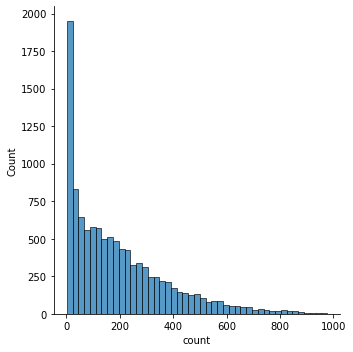

In [17]:
sns.displot(data=data_train , x='count')

<div class="alert alert-block alert-warning">
    <h4 align="center">January, Februray and March have the least average count due to bad weather</h4>
</div>

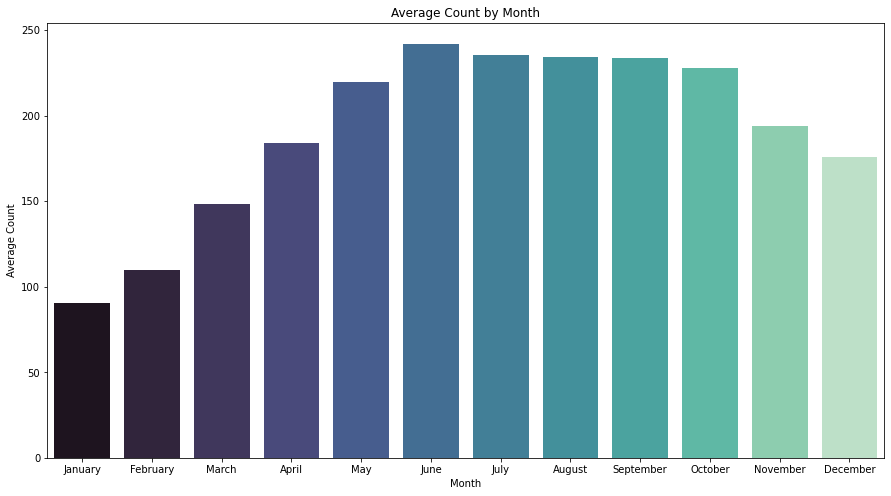

In [18]:
plt.figure(figsize=(15,8))
sort_order = sortOrder = ["January","February","March","April","May","June","July","August","September","October","November","December"]
data = data_train.groupby('month')['count'].mean().reset_index()
sns.barplot(data=data , x='month' , y='count' , order=sort_order , palette='mako')
plt.title('Average Count by Month')
plt.xlabel('Month')
plt.ylabel('Average Count')
plt.show()

<div class="alert alert-block alert-warning">
    <h4 align="center">Aside from weekends, average count increase in time range of 5 to 9 and 16 to 19 which corresponds to                          going can comming back from work. In weekends average count is higher at time range of 10 to 20</h4>
</div>

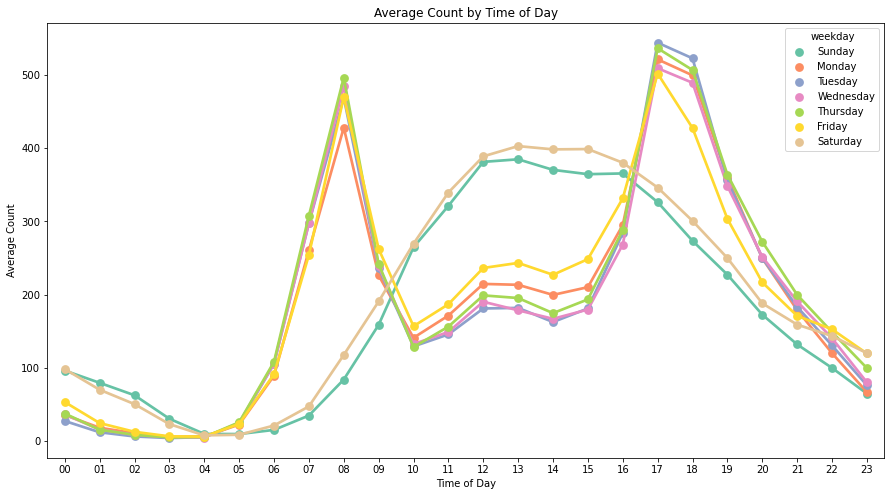

In [19]:
hue_order = ["Sunday","Monday","Tuesday","Wednesday","Thursday","Friday","Saturday"]
plt.figure(figsize=(15,8))
data = data_train.groupby(['hour' , 'weekday'])['count'].mean().reset_index()
sns.pointplot(data=data , x='hour' , y='count' , hue='weekday' , hue_order=hue_order , join=True , palette='Set2')
plt.title('Average Count by Time of Day')
plt.xlabel('Time of Day')
plt.ylabel('Average Count')
plt.show()

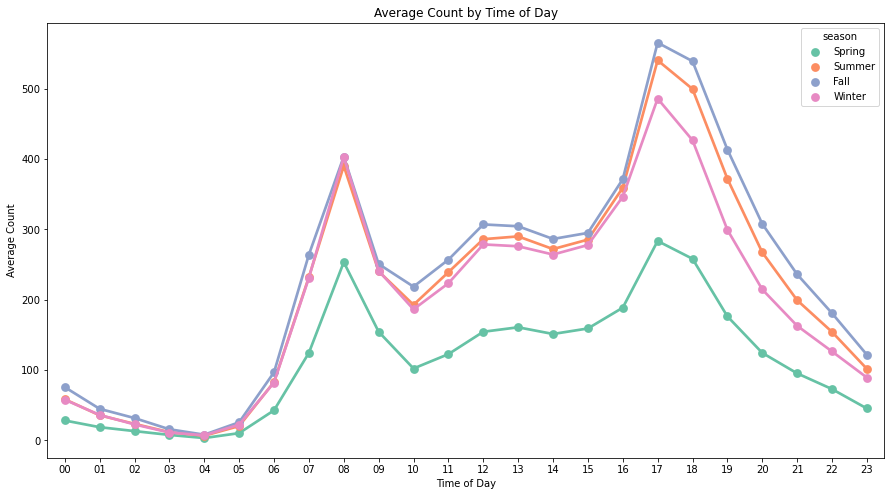

In [20]:
hue_order = ["Sunday","Monday","Tuesday","Wednesday","Thursday","Friday","Saturday"]
plt.figure(figsize=(15,8))
data = data_train.groupby(['hour' , 'season'])['count'].mean().reset_index()
sns.pointplot(data=data , x='hour' , y='count' , hue='season' , hue_order=['Spring' , 'Summer' , 'Fall' , 'Winter'] , join=True , palette='Set2')
plt.title('Average Count by Time of Day')
plt.xlabel('Time of Day')
plt.ylabel('Average Count')
plt.show()

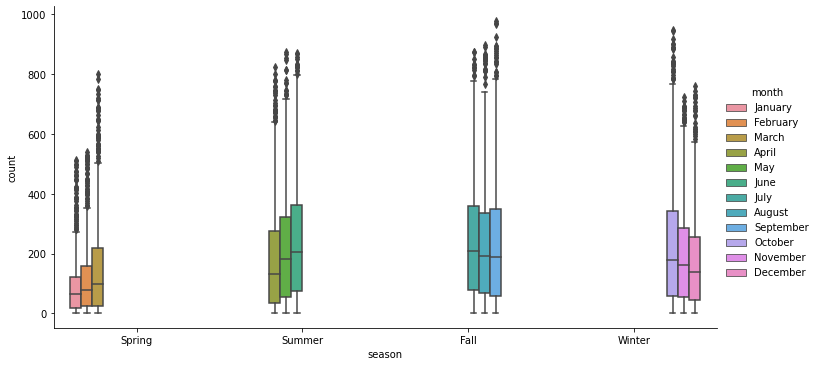

In [21]:
sns.catplot(x='season' , y='count' , hue='month' , kind='box' , data=data_train , aspect=2)
plt.show()

<div class="alert alert-block alert-info">
    <h2 align="center">Data Preprocessing</h2>
</div>

<div class="alert alert-block alert-warning">
    <ul>
        <li>Dropping useless features (Datetime , Casual , Registered)</li>
        <li>One hot encoding season, weather and weekday</li>
        <li>Label encoding month</li>
    </ul>
</div>

In [22]:
data_train = data_train.drop(['datetime' , 'date' , 'casual' , 'registered'] , axis=1)

In [23]:
data_train = pd.concat([data_train , pd.get_dummies(data_train['season'])] , axis=1)
data_train = pd.concat([data_train , pd.get_dummies(data_train['weather'])] , axis=1)
data_train = pd.concat([data_train , pd.get_dummies(data_train['weekday'])] , axis=1)
data_train = data_train.drop(['season' , 'weather' , 'weekday'] , axis=1)

In [24]:
data_train.replace({'month' : {"January" : 0,
                               "February": 1,
                               "March" : 2,
                               "April" : 3,
                               "May" : 4,
                               "June" : 5,
                               "July" : 6,
                               "August" : 7,
                               "September" : 8,
                               "October" : 9,
                               "November" : 10,
                               "December" : 11}} , inplace=True)

In [25]:
count = data_train[['count']]
data_train = data_train.drop('count' , axis=1)
data_train = pd.concat([data_train , count] , axis=1)

In [26]:
data_train.hour = data_train.hour.astype('int64')

<div class="alert alert-block alert-warning">
    <ul>
        <li>Understanding features relation to target</li>
    </ul>
</div>

<AxesSubplot:>

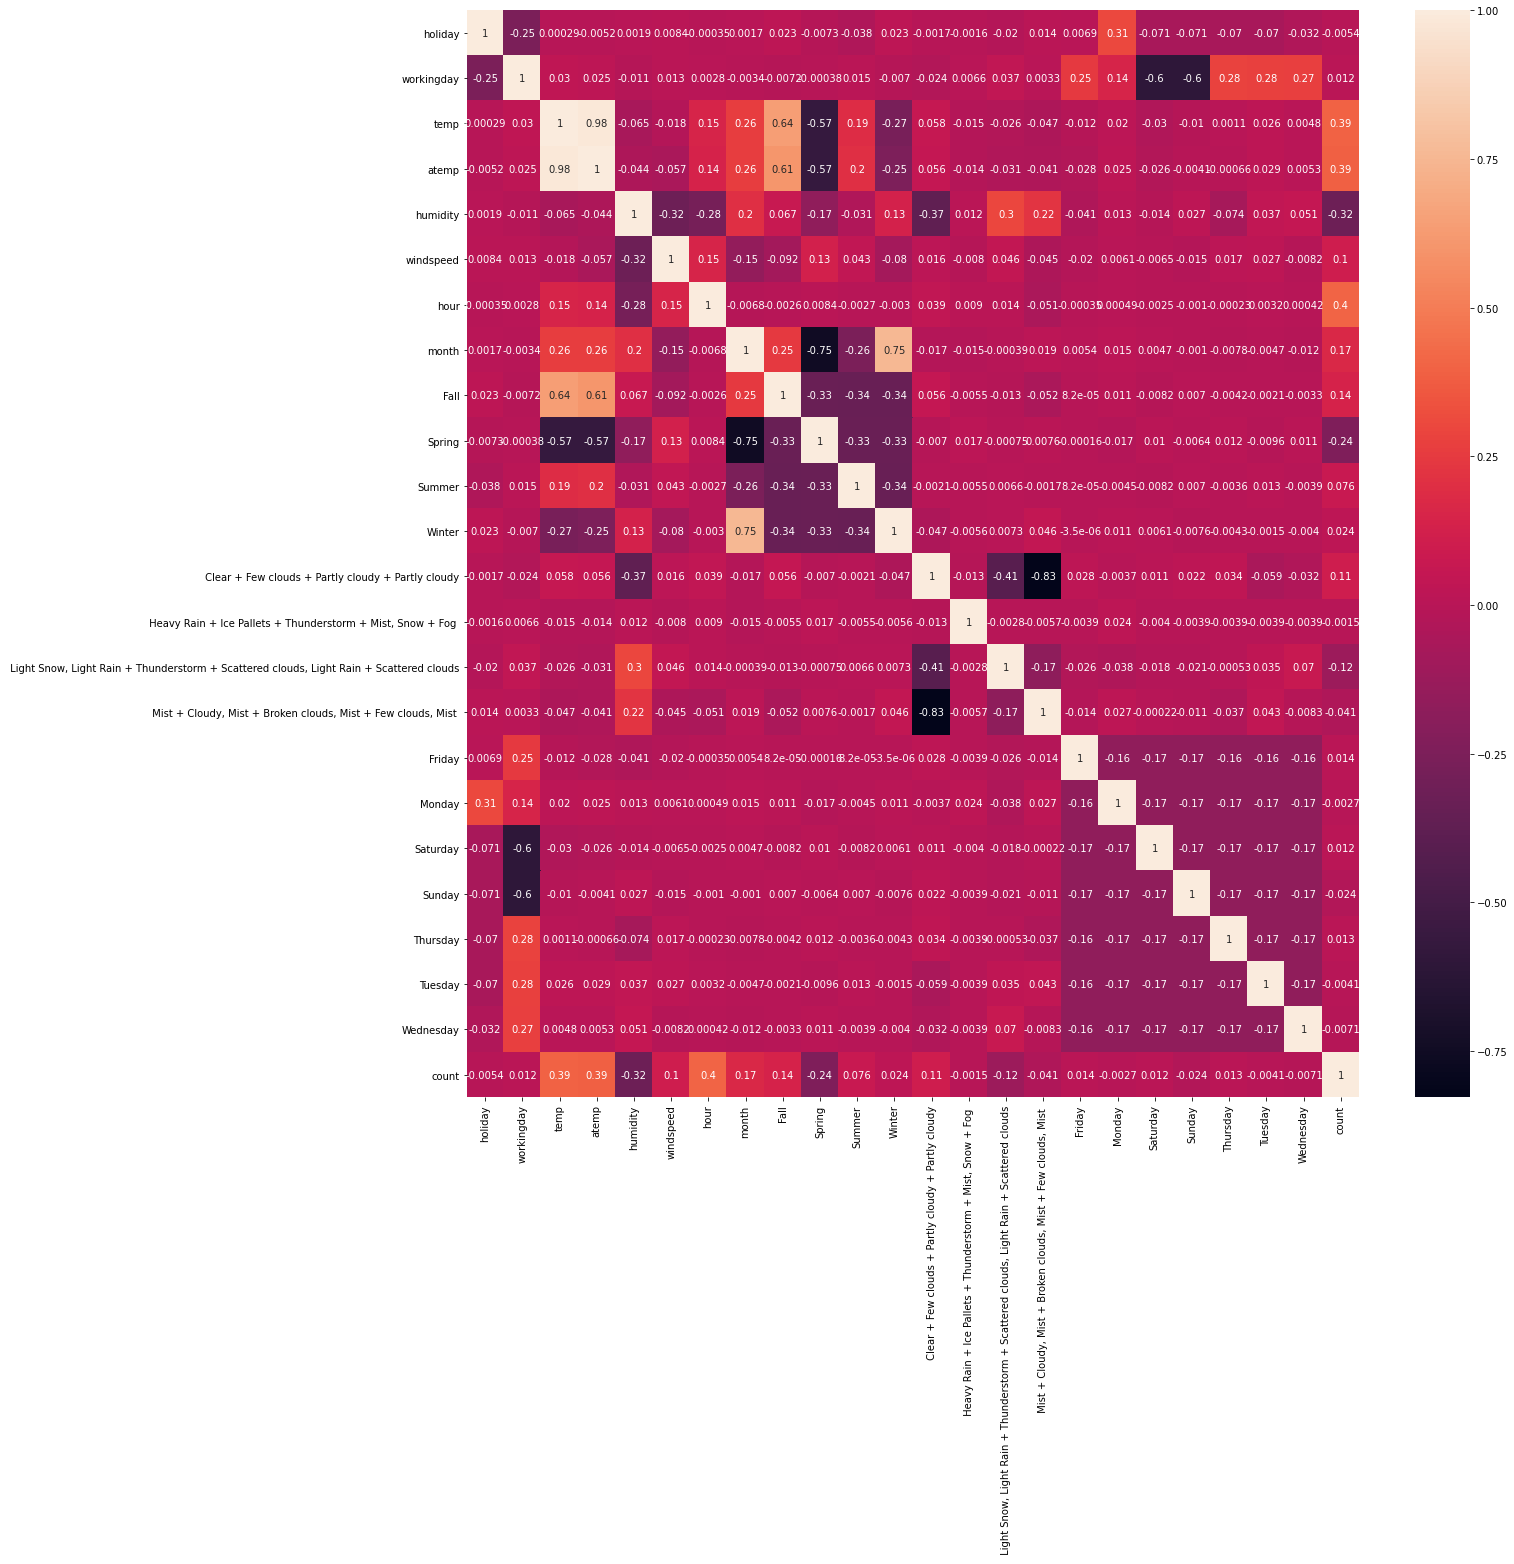

In [27]:
plt.figure(figsize=(20 , 20))
sns.heatmap(data_train.corr() , annot=True)

<div class="alert alert-block alert-warning">
    <ul>
        <li>Splitting data into train and test</li>
        <li>Scaling features that are not categorical</li>
    </ul>
</div>

In [28]:
x = data_train.iloc[: , :-1].values
y = data_train.iloc[:  , -1].values
print(x.shape , y.shape)

(10886, 23) (10886,)


In [29]:
x_train , x_test , y_train , y_test = train_test_split(x , y , test_size=0.25 , random_state=26)
print(x_train.shape , y_train.shape)
print(x_test.shape , y_test.shape)

(8164, 23) (8164,)
(2722, 23) (2722,)


In [30]:
sc = StandardScaler()
x_train[: , 2:6] = sc.fit_transform(x_train[: , 2:6])
x_test[: , 2:6] = sc.transform(x_test[: , 2:6])

In [31]:
scoring = ['neg_mean_absolute_error' , 'neg_mean_squared_error' , 'neg_root_mean_squared_error' , 'r2']

<div class="alert alert-block alert-info">
    <h2 align="center">Train your model (Regression)</h2>
</div>

<div class="alert alert-block alert-danger">
    <h3 align="center">Simple Linear Regression for all features</h3>
</div>

Metrics for holiday
R^2 : -0.0028808309550805156
RMSE : 186.6548779447962
------------------------------------
Metrics for workingday
R^2 : -0.0033747916235669084
RMSE : 186.70083994502974
------------------------------------
Metrics for temp
R^2 : 0.15528370722885654
RMSE : 171.30502963235335
------------------------------------
Metrics for atemp
R^2 : 0.14958803036487733
RMSE : 171.88158942625174
------------------------------------
Metrics for humidity
R^2 : 0.0893953018909247
RMSE : 177.86054642260189
------------------------------------
Metrics for windspeed
R^2 : 0.006635436138238693
RMSE : 185.7671894849147
------------------------------------
Metrics for hour
R^2 : 0.14870977049935064
RMSE : 171.97032156556853
------------------------------------
Metrics for month
R^2 : 0.026987522339780745
RMSE : 183.85433896801865
------------------------------------
Metrics for Fall
R^2 : 0.01819480737579504
RMSE : 184.6831788611715
------------------------------------
Metrics for Spring
R^2

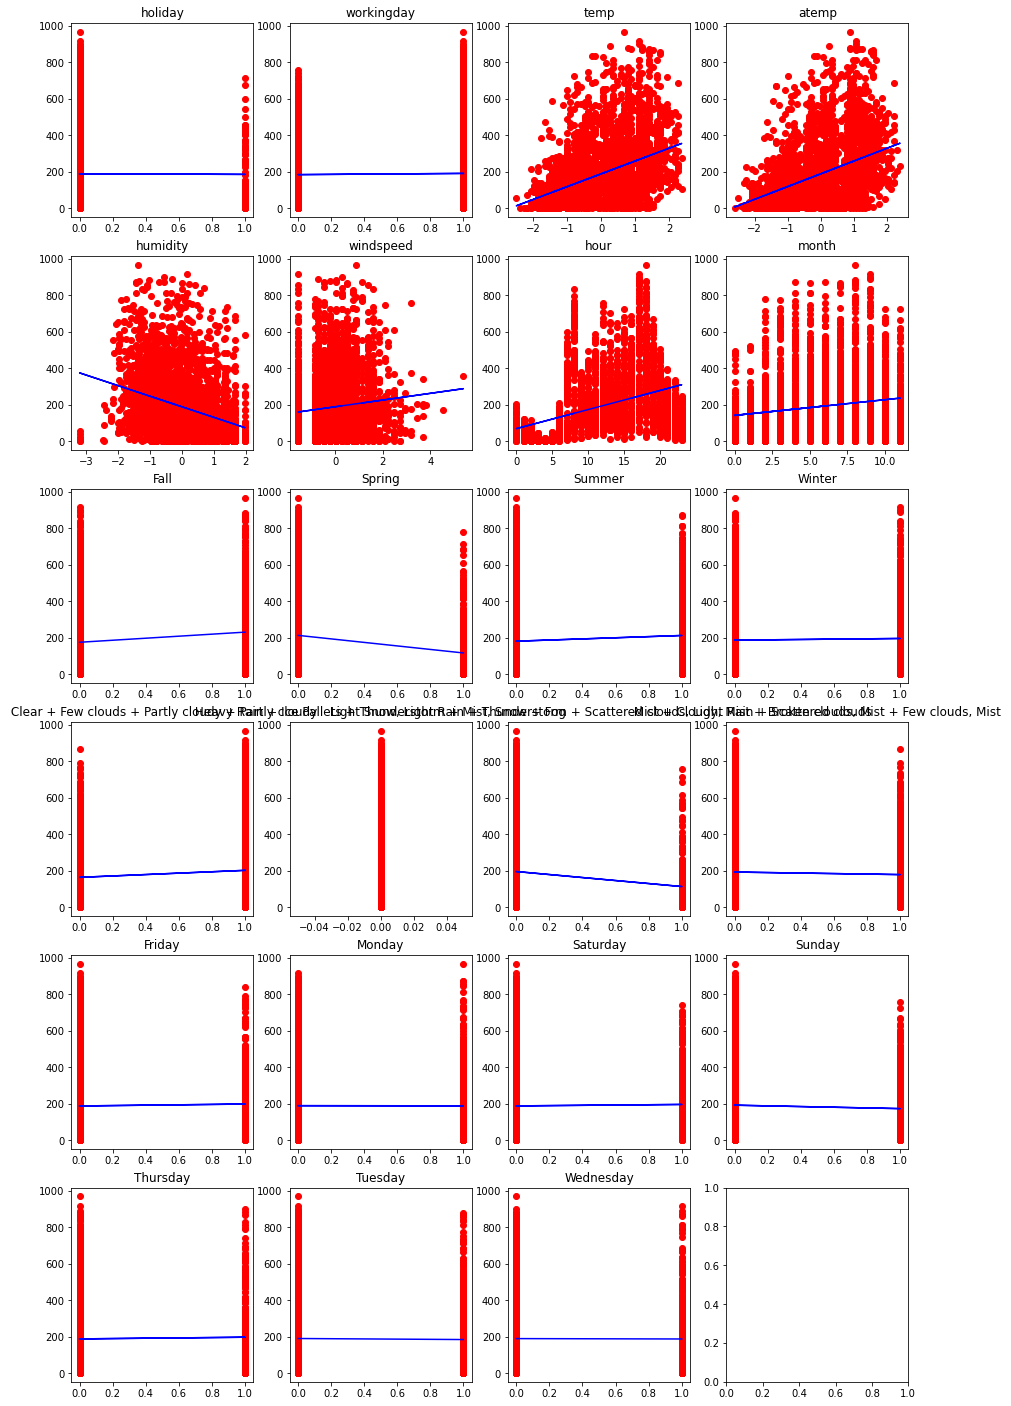

In [32]:
fig,ax = plt.subplots(6,4 , figsize=(15,25))
counter = 0

for i in range(0 , 6):
    for j in range(0 , 4):
        
        if counter == 23 :
            break
        
        # Training model
        regressor = LinearRegression()
        regressor.fit(x_train[: , counter].reshape(-1,1) , y_train)
        
        # Predicting result with test
        y_pred = regressor.predict(x_test[: , counter].reshape(-1,1))
        
        print(f'Metrics for {data_train.columns[counter]}')
        print(f'R^2 : {metrics.r2_score(y_test , y_pred)}')
        print(f'RMSE : {np.sqrt(metrics.mean_squared_error(y_test , y_pred))}')
        print('------------------------------------')
        
        ax[i,j].scatter(x_test[: , counter].reshape(-1,1) , y_test , color='red')
        ax[i,j].plot(x_test[: , counter].reshape(-1,1) , y_pred , color='blue')
        ax[i,j].set_title(data_train.columns[counter])
        counter +=1
        
plt.show()

<div class="alert alert-block alert-danger">
    <h3 align="center">Multiple Linear Regression</h3>
</div>

In [33]:
multiple_regressor = LinearRegression()
scores = cross_validate(estimator=multiple_regressor , X=x_train , y=y_train , cv=10 ,scoring=scoring)
print(f"MAE : {scores['test_neg_mean_absolute_error'].mean()}")
print(f"MSE : {scores['test_neg_mean_squared_error'].mean()}")
print(f"RMSE : {scores['test_neg_root_mean_squared_error'].mean()}")
print(f"R^2 : {scores['test_r2'].mean()}")

MAE : -106.21926320525279
MSE : -20905.402936117258
RMSE : -144.5181630895438
R^2 : 0.348474531309077


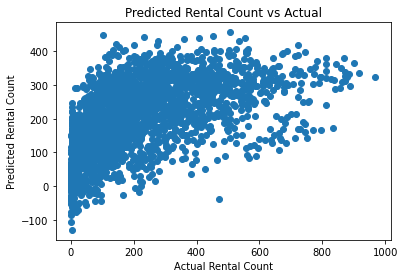

In [34]:
multiple_regressor.fit(x_train , y_train)
y_pred = multiple_regressor.predict(x_test)
plt.scatter(y_test , y_pred)
plt.title('Predicted Rental Count vs Actual')
plt.xlabel('Actual Rental Count')
plt.ylabel('Predicted Rental Count')
plt.show()

In [35]:
print(f'MAE : {metrics.mean_absolute_error(y_test , y_pred)}')
print(f'MSE : {metrics.mean_squared_error(y_test , y_pred)}')
print(f'RMSE : {np.sqrt(metrics.mean_squared_error(y_test , y_pred))}')
print(f'R^2 : {metrics.r2_score(y_test , y_pred)}')

MAE : 112.20853143517567
MSE : 23060.26630436284
RMSE : 151.85607101582355
R^2 : 0.33620349642998537


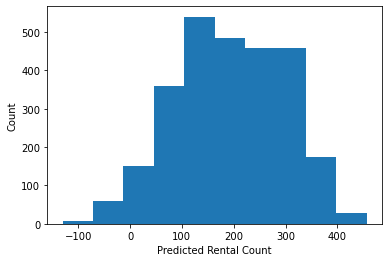

In [36]:
plt.hist(y_pred)
plt.xlabel('Predicted Rental Count')
plt.ylabel('Count')
plt.show()

<div class="alert alert-block alert-danger">
    <h3 align="center">Polynomial Linear Regression (Degree=2)</h3>
</div>

In [37]:
# Creating polynomial regressor
poly_features = PolynomialFeatures(degree=2)
x_train_quadratic = poly_features.fit_transform(x_train)
quadratic_regressor = LinearRegression()

# Cross validation for polynomial regression
scores = cross_validate(estimator=quadratic_regressor , X=x_train_quadratic , y=y_train , cv=10 ,scoring=scoring)
print(f"MAE : {scores['test_neg_mean_absolute_error'].mean()}")
print(f"MSE : {scores['test_neg_mean_squared_error'].mean()}")
print(f"RMSE : {scores['test_neg_root_mean_squared_error'].mean()}")
print(f"R^2 : {scores['test_r2'].mean()}")

MAE : -94.3459676022929
MSE : -16324.298628901208
RMSE : -127.7258674695477
R^2 : 0.4907208554698591


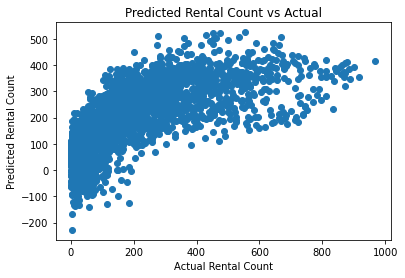

In [38]:
quadratic_regressor.fit(x_train_quadratic , y_train)
y_pred = quadratic_regressor.predict(poly_features.fit_transform(x_test))
plt.scatter(y_test , y_pred)
plt.title('Predicted Rental Count vs Actual')
plt.xlabel('Actual Rental Count')
plt.ylabel('Predicted Rental Count')
plt.show()

In [39]:
print(f'MAE : {metrics.mean_absolute_error(y_test , y_pred)}')
print(f'MSE : {metrics.mean_squared_error(y_test , y_pred)}')
print(f'RMSE : {np.sqrt(metrics.mean_squared_error(y_test , y_pred))}')
print(f'R^2 : {metrics.r2_score(y_test , y_pred)}')

MAE : 98.47898131004725
MSE : 17748.590657561337
RMSE : 133.22383667182586
R^2 : 0.48910163194621603


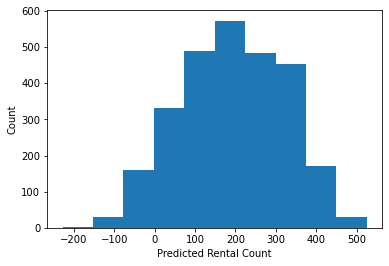

In [40]:
plt.hist(y_pred)
plt.xlabel('Predicted Rental Count')
plt.ylabel('Count')
plt.show()

<div class="alert alert-block alert-danger">
    <h3 align="center">K Nearest Neighbor</h3>
</div>

<div class="alert alert-block alert-warning">
    <ul>
        <li>K = 10 is the best hyper parameter in K Nearest Neighbor</li>
    </ul>
</div>

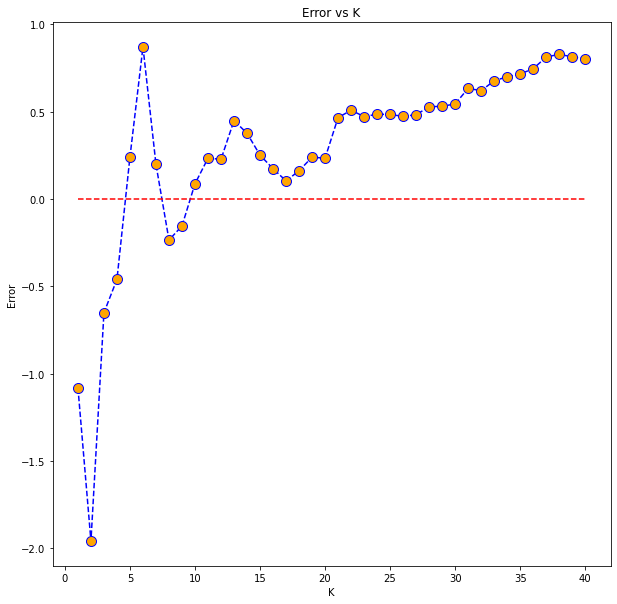

In [41]:
error = []

for i in range (1,41):
    
    knn = KNeighborsRegressor(n_neighbors=i)
    knn.fit(x_train , y_train)
    y_pred_i = knn.predict(x_test)
    error.append(np.mean(y_pred_i) - np.mean(y_test))
    
plt.figure(figsize=(10,10))
plt.plot(range(1,41) , error , color='blue' , marker='o' , linestyle='dashed' , markersize=10 , markerfacecolor='orange')
plt.plot(range(1,41) , np.zeros((40,)) , color='red' , linestyle='dashed')
plt.title('Error vs K')
plt.xlabel('K')
plt.ylabel('Error')
plt.show()

In [42]:
knn = KNeighborsRegressor()

parameters = [{'n_neighbors' : [3,4,5,6,7,8,9,10,11]}]
grid_search = GridSearchCV(estimator=knn , param_grid=parameters , scoring='r2' , cv=10 , n_jobs=-1)
grid_search.fit(x_train , y_train)

print(f'Best Scores : {grid_search.best_score_}')
print(f'Best Parameter : {grid_search.best_params_}')

Best Scores : 0.8148821757757594
Best Parameter : {'n_neighbors': 7}


In [43]:
knn = KNeighborsRegressor(n_neighbors=7)

scores = cross_validate(estimator=knn , X=x_train , y=y_train , cv=10 ,scoring=scoring)
print(f"MAE : {scores['test_neg_mean_absolute_error'].mean()}")
print(f"MSE : {scores['test_neg_mean_squared_error'].mean()}")
print(f"RMSE : {scores['test_neg_root_mean_squared_error'].mean()}")
print(f"R^2 : {scores['test_r2'].mean()}")

MAE : -50.33056866259356
MSE : -5929.27757026005
RMSE : -76.97685683949719
R^2 : 0.8148821757757594


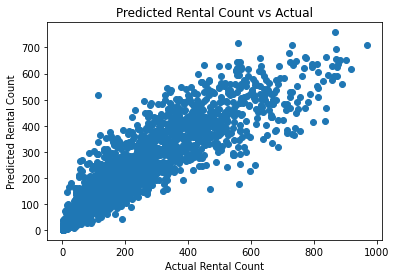

In [44]:
knn.fit(x_train , y_train)
y_pred = knn.predict(x_test)
plt.scatter(y_test , y_pred)
plt.title('Predicted Rental Count vs Actual')
plt.xlabel('Actual Rental Count')
plt.ylabel('Predicted Rental Count')
plt.show()

In [45]:
print(f'MAE : {metrics.mean_absolute_error(y_test , y_pred)}')
print(f'MSE : {metrics.mean_squared_error(y_test , y_pred)}')
print(f'RMSE : {np.sqrt(metrics.mean_squared_error(y_test , y_pred))}')
print(f'R^2 : {metrics.r2_score(y_test , y_pred)}')

MAE : 51.004985829747035
MSE : 6070.799854548727
RMSE : 77.91533773621678
R^2 : 0.8252502523546144


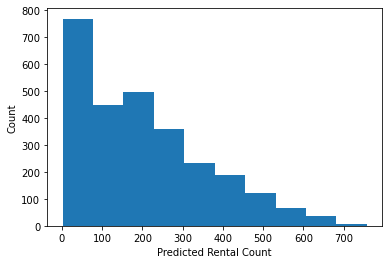

In [46]:
plt.hist(y_pred)
plt.xlabel('Predicted Rental Count')
plt.ylabel('Count')
plt.show()

<div class="alert alert-block alert-danger">
    <h3 align="center">Decision Tree Regression</h3>
</div>

In [47]:
dt_regressor = DecisionTreeRegressor()

scores = cross_validate(estimator=dt_regressor , X=x_train , y=y_train , cv=10 ,scoring=scoring)
print(f"MAE : {scores['test_neg_mean_absolute_error'].mean()}")
print(f"MSE : {scores['test_neg_mean_squared_error'].mean()}")
print(f"RMSE : {scores['test_neg_root_mean_squared_error'].mean()}")
print(f"R^2 : {scores['test_r2'].mean()}")

MAE : -57.432706788345705
MSE : -8711.737465650276
RMSE : -93.25199524719787
R^2 : 0.7275296010182328


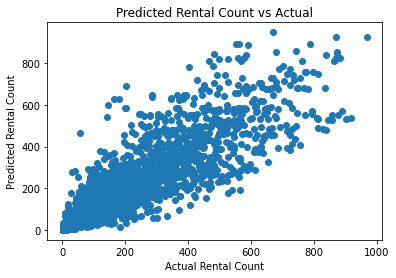

In [48]:
dt_regressor.fit(x_train , y_train)
y_pred = dt_regressor.predict(x_test)
plt.scatter(y_test , y_pred)
plt.title('Predicted Rental Count vs Actual')
plt.xlabel('Actual Rental Count')
plt.ylabel('Predicted Rental Count')
plt.show()

In [49]:
print(f'MAE : {metrics.mean_absolute_error(y_test , y_pred)}')
print(f'MSE : {metrics.mean_squared_error(y_test , y_pred)}')
print(f'RMSE : {np.sqrt(metrics.mean_squared_error(y_test , y_pred))}')
print(f'R^2 : {metrics.r2_score(y_test , y_pred)}')

MAE : 57.10598824393828
MSE : 8416.64814474651
RMSE : 91.74229201816635
R^2 : 0.7577243238858533


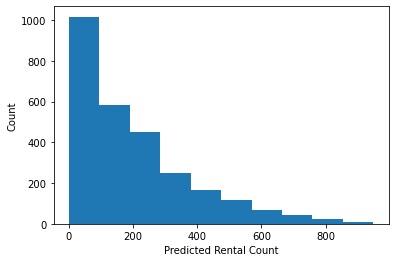

In [50]:
plt.hist(y_pred)
plt.xlabel('Predicted Rental Count')
plt.ylabel('Count')
plt.show()

<div class="alert alert-block alert-danger">
    <h3 align="center">Random Forest Regression</h3>
</div>

In [51]:
rf_regressor = RandomForestRegressor()

parameters = [{'n_estimators' : [100,200,300]}]
grid_search = GridSearchCV(estimator=rf_regressor , param_grid=parameters , scoring='r2' , cv=10 , n_jobs=-1)
grid_search.fit(x_train , y_train)

print(f'Best Score : {grid_search.best_score_}')
print(f'Best Parameter : {grid_search.best_params_}')

Best Score : 0.8589043973457746
Best Parameter : {'n_estimators': 300}


In [52]:
rf_regressor = RandomForestRegressor(n_estimators=200)

scores = cross_validate(estimator=rf_regressor , X=x_train , y=y_train , cv=10 , scoring=scoring)
print(f"MAE : {scores['test_neg_mean_absolute_error'].mean()}")
print(f"MSE : {scores['test_neg_mean_squared_error'].mean()}")
print(f"RMSE : {scores['test_neg_root_mean_squared_error'].mean()}")
print(f"R^2 : {scores['test_r2'].mean()}")

MAE : -44.33584970003543
MSE : -4519.298876605867
RMSE : -67.18814755388105
R^2 : 0.8586777621324849


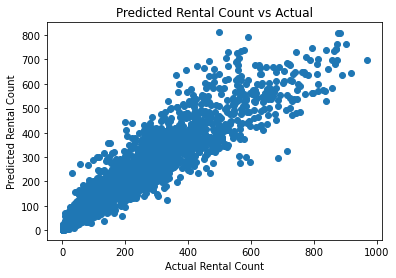

In [53]:
rf_regressor.fit(x_train , y_train)
y_pred = rf_regressor.predict(x_test)
plt.scatter(y_test , y_pred)
plt.title('Predicted Rental Count vs Actual')
plt.xlabel('Actual Rental Count')
plt.ylabel('Predicted Rental Count')
plt.show()

In [54]:
print(f'MAE : {metrics.mean_absolute_error(y_test , y_pred)}')
print(f'MSE : {metrics.mean_squared_error(y_test , y_pred)}')
print(f'RMSE : {np.sqrt(metrics.mean_squared_error(y_test , y_pred))}')
print(f'R^2 : {metrics.r2_score(y_test , y_pred)}')

MAE : 43.97083086665967
MSE : 4385.911165066045
RMSE : 66.22621206943701
R^2 : 0.8737502655904402


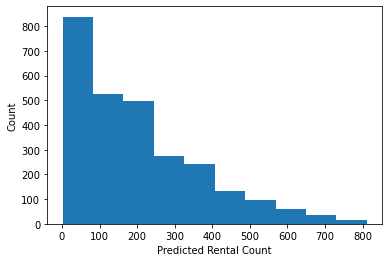

In [55]:
plt.hist(y_pred)
plt.xlabel('Predicted Rental Count')
plt.ylabel('Count')
plt.show()

<div class="alert alert-block alert-danger">
    <h3 align="center">XGBoost Regression</h3>
</div>

In [56]:
xgb_reg = xgb.XGBRegressor(
    subsample=0.75,
    colsample_bytree=1, 
    max_depth=7,
)

parameters = [{'n_estimators' : [100,200,300] , 'learning_rate' : [0.06,0.08,0.1] , 'gamma': [0.0,0.1, 0.2,]}]
grid_search = GridSearchCV(estimator=xgb_reg , param_grid=parameters , scoring='r2' , cv=10 , n_jobs=-1)
grid_search.fit(x_train , y_train)

print(f'Best Score : {grid_search.best_score_}')
print(f'Best Parameter : {grid_search.best_params_}')

Best Score : 0.8887684085928271
Best Parameter : {'gamma': 0.0, 'learning_rate': 0.1, 'n_estimators': 300}


In [57]:
xgb_reg = xgb.XGBRegressor(
    n_estimators = 300,
    learning_rate = 0.1,
    subsample=0.75,
    colsample_bytree=1, 
    max_depth=7,
    gamma=0,
)

scores = cross_validate(estimator=xgb_reg , X=x_train , y=y_train , cv=10 , scoring=scoring)
print(f"MAE : {scores['test_neg_mean_absolute_error'].mean()}")
print(f"MSE : {scores['test_neg_mean_squared_error'].mean()}")
print(f"RMSE : {scores['test_neg_root_mean_squared_error'].mean()}")
print(f"R^2 : {scores['test_r2'].mean()}")

MAE : -39.14111037352736
MSE : -3557.339247844003
RMSE : -59.611385186847386
R^2 : 0.8887684085928271


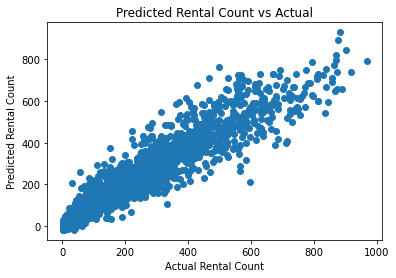

In [58]:
xgb_reg.fit(x_train , y_train)
y_pred = xgb_reg.predict(x_test)
plt.scatter(y_test , y_pred)
plt.title('Predicted Rental Count vs Actual')
plt.xlabel('Actual Rental Count')
plt.ylabel('Predicted Rental Count')
plt.show()

In [59]:
print(f'MAE : {metrics.mean_absolute_error(y_test , y_pred)}')
print(f'MSE : {metrics.mean_squared_error(y_test , y_pred)}')
print(f'RMSE : {np.sqrt(metrics.mean_squared_error(y_test , y_pred))}')
print(f'R^2 : {metrics.r2_score(y_test , y_pred)}')

MAE : 39.71672620346481
MSE : 3625.6019068502565
RMSE : 60.21297125080489
R^2 : 0.8956359897435939


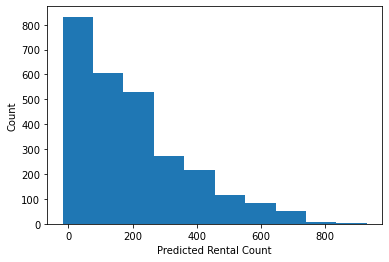

In [60]:
plt.hist(y_pred)
plt.xlabel('Predicted Rental Count')
plt.ylabel('Count')
plt.show()

<div class="alert alert-block alert-danger">
    <h3 align="center">Support Vector Regression</h3>
</div>

In [61]:
svr_reg = SVR()

parameters = [{'kernel' : ['linear', 'poly', 'rbf', 'sigmoid']}]
grid_search = GridSearchCV(estimator=svr_reg , param_grid=parameters , scoring='r2' , cv=10 , n_jobs=-1)
grid_search.fit(x_train , y_train)

print(f'Best Score : {grid_search.best_score_}')
print(f'Best Parameter : {grid_search.best_params_}')

Best Score : 0.3661571275087075
Best Parameter : {'kernel': 'rbf'}


In [62]:
svr_reg = SVR(kernel='rbf')

scores = cross_validate(estimator=svr_reg , X=x_train , y=y_train , cv=10 , scoring=scoring)
print(f"MAE : {scores['test_neg_mean_absolute_error'].mean()}")
print(f"MSE : {scores['test_neg_mean_squared_error'].mean()}")
print(f"RMSE : {scores['test_neg_root_mean_squared_error'].mean()}")
print(f"R^2 : {scores['test_r2'].mean()}")

MAE : -91.70343330695991
MSE : -20360.521419704313
RMSE : -142.58396661159983
R^2 : 0.3661571275087075


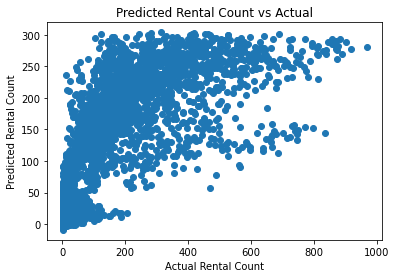

In [63]:
svr_reg.fit(x_train , y_train)
y_pred = svr_reg.predict(x_test)
plt.scatter(y_test , y_pred)
plt.title('Predicted Rental Count vs Actual')
plt.xlabel('Actual Rental Count')
plt.ylabel('Predicted Rental Count')
plt.show()

In [64]:
print(f'MAE : {metrics.mean_absolute_error(y_test , y_pred)}')
print(f'MSE : {metrics.mean_squared_error(y_test , y_pred)}')
print(f'RMSE : {np.sqrt(metrics.mean_squared_error(y_test , y_pred))}')
print(f'R^2 : {metrics.r2_score(y_test , y_pred)}')

MAE : 97.01055575917431
MSE : 22575.617634027505
RMSE : 150.25184735645516
R^2 : 0.3501542500154975


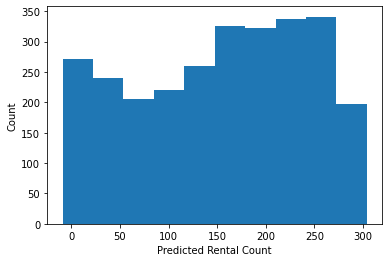

In [65]:
plt.hist(y_pred)
plt.xlabel('Predicted Rental Count')
plt.ylabel('Count')
plt.show()

<div class="alert alert-block alert-info">
    <h1 align="center">Test Result</h1>
</div>

<div class="alert alert-block alert-warning">
    <ul>
        <li>Importing test data</li>
        <li>Converting to orginal data form</li>
        <li>Encoding and scaling it for training</li>
        <li>Evaluating whether the predicted data is correct</li>
    </ul>
</div>

In [66]:
data_test = pd.read_csv('test.csv')

# converting datetime into a usable format
data_test["date"] = data_test.datetime.apply(lambda x : x.split()[0])
data_test["hour"] = data_test.datetime.apply(lambda x : x.split()[1].split(":")[0])
data_test["weekday"] = data_test.date.apply(lambda dateString : calendar.day_name[datetime.strptime(dateString,"%Y-%m-%d").weekday()])
data_test["month"] = data_test.date.apply(lambda dateString : calendar.month_name[datetime.strptime(dateString,"%Y-%m-%d").month])

# converting categorical data for later encoding
data_test["season"] = data_test.season.map({1: "Spring", 2 : "Summer", 3 : "Fall", 4 :"Winter" })
data_test["weather"] = data_test.weather.map({1: " Clear + Few clouds + Partly cloudy + Partly cloudy",\
                                        2 : " Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist ", \
                                        3 : " Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds", \
                                        4 :" Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog " })


data_test_modeling = data_test.copy()

# droping useless features
data_test_modeling = data_test_modeling.drop(['datetime' , 'date'] , axis=1)

# encoding categorical data and dropping the original column
data_test_modeling = pd.concat([data_test_modeling , pd.get_dummies(data_test_modeling['season'])] , axis=1)
data_test_modeling = pd.concat([data_test_modeling , pd.get_dummies(data_test_modeling['weather'])] , axis=1)
data_test_modeling = pd.concat([data_test_modeling , pd.get_dummies(data_test_modeling['weekday'])] , axis=1)
data_test_modeling = data_test_modeling.drop(['season' , 'weather' , 'weekday'] , axis=1)
data_test_modeling.replace({'month' : {"January" : 0,
                               "February": 1,
                               "March" : 2,
                               "April" : 3,
                               "May" : 4,
                               "June" : 5,
                               "July" : 6,
                               "August" : 7,
                               "September" : 8,
                               "October" : 9,
                               "November" : 10,
                               "December" : 11}} , inplace=True)

# changing the type of hour column
data_test_modeling.hour = data_train.hour.astype('int64')
data_test_modeling.sample()

,holiday,workingday,temp,atemp,humidity,windspeed,hour,month,Fall,Spring,...,"Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog","Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds","Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist",Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
2447,0,0,18.86,22.725,55,6.0032,21,9,0,0,...,0,0,0,0,0,1,0,0,0,0


In [67]:
# creating x test for prediction
x_data_test = data_test_modeling.values

# Scaling x
x_data_test[: , 2:6] = sc.transform(x_data_test[: , 2:6])

<div class="alert alert-block alert-danger">
    <h3 align="center">New Data - Multiple Regression Prediction</h3>
</div>

<div class="alert alert-block alert-warning">
    <ul>
        <li>Rental distribuation isn't normal</li>
        <li>Model predicted negative values which should be immpossible</li>
        <li>Average rental count across month is close to actuall data</li>
        <li>Average rental count across time of day per weekday and season is also close to actuall data but has variation</li>
    </ul>
</div>

In [68]:
y_data_pred = multiple_regressor.predict(x_data_test) 

In [69]:
predicted = pd.DataFrame(y_data_pred.reshape(-1,1) , columns=['Predicted Count'])
mr_data = pd.concat([data_test , predicted] , axis=1)
mr_data.sample()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,date,hour,weekday,month,Predicted Count
6141,2012-11-28 05:00:00,Winter,0,1,"Mist + Cloudy, Mist + Broken clouds, Mist + F...",10.66,13.635,70,8.9981,2012-11-28,05,Wednesday,November,86.586906


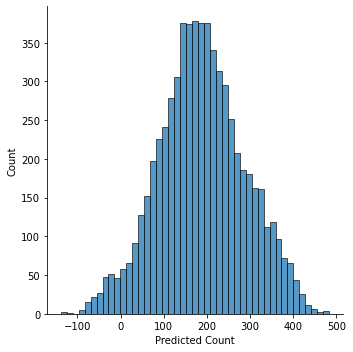

In [70]:
sns.displot(data=mr_data , x='Predicted Count')

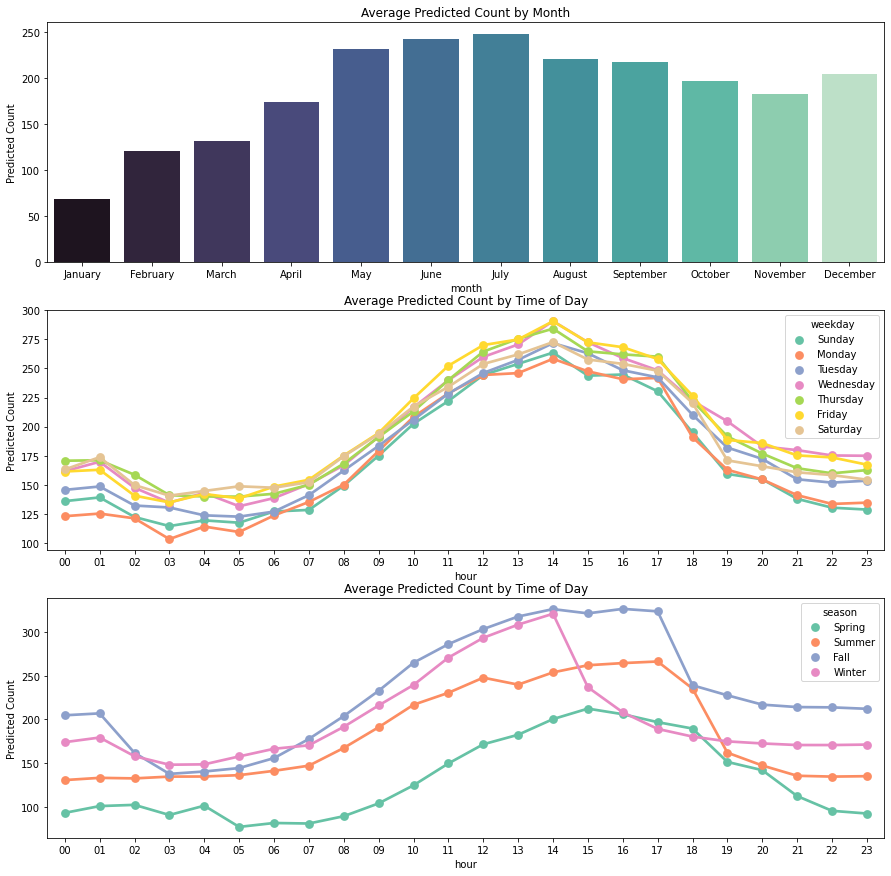

<Figure size 1080x576 with 0 Axes>

In [71]:
fig,ax = plt.subplots(3, figsize=(15,15))

sort_order = ["January","February","March","April","May","June","July","August","September","October","November","December"]
data = mr_data.groupby('month')['Predicted Count'].mean().reset_index()
sns.barplot(data=data , x='month' , y='Predicted Count', ax=ax[0] , order=sort_order , palette='mako')
ax[0].set_title('Average Predicted Count by Month')

hue_order = ["Sunday","Monday","Tuesday","Wednesday","Thursday","Friday","Saturday"]
data = mr_data.groupby(['hour' , 'weekday'])['Predicted Count'].mean().reset_index()
sns.pointplot(data=data , x='hour' , y='Predicted Count' , ax=ax[1] , hue='weekday' , hue_order=hue_order , join=True , palette='Set2')
ax[1].set_title('Average Predicted Count by Time of Day')

hue_order = ["Sunday","Monday","Tuesday","Wednesday","Thursday","Friday","Saturday"]
plt.figure(figsize=(15,8))
data = mr_data.groupby(['hour' , 'season'])['Predicted Count'].mean().reset_index()
sns.pointplot(data=data , x='hour' , y='Predicted Count' , ax=ax[2] , hue='season' , hue_order=['Spring' , 'Summer' , 'Fall' , 'Winter'] , join=True , palette='Set2')
ax[2].set_title('Average Predicted Count by Time of Day')


plt.show()

<div class="alert alert-block alert-danger">
    <h3 align="center">New Data - Polynomial Regression Prediction</h3>
</div>

<div class="alert alert-block alert-warning">
    <ul>
        <li>Rental distribuation isn't normal</li>
        <li>Model predicted negative values which should be immpossible</li>
        <li>Polynomial model is the worst model and predicted some crazy values</li>
        <li>Average rental count across time of day per weekday and season and across month is all over the place</li>
    </ul>
</div>

In [72]:
y_data_pred = quadratic_regressor.predict(poly_features.fit_transform(x_data_test))
predicted = pd.DataFrame(y_data_pred.reshape(-1,1) , columns=['Predicted Count'])
quadratic_data = pd.concat([data_test , predicted] , axis=1)
quadratic_data.sample()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,date,hour,weekday,month,Predicted Count
6237,2012-12-21 06:00:00,Spring,0,1,"Mist + Cloudy, Mist + Broken clouds, Mist + F...",13.94,14.395,57,39.0007,2012-12-21,06,Friday,December,-281.757991


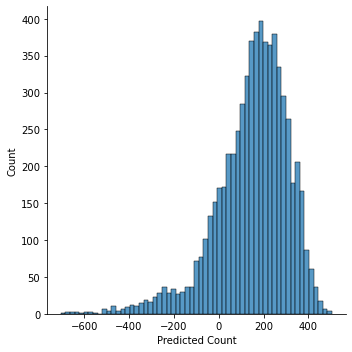

In [73]:
sns.displot(data=quadratic_data , x='Predicted Count')

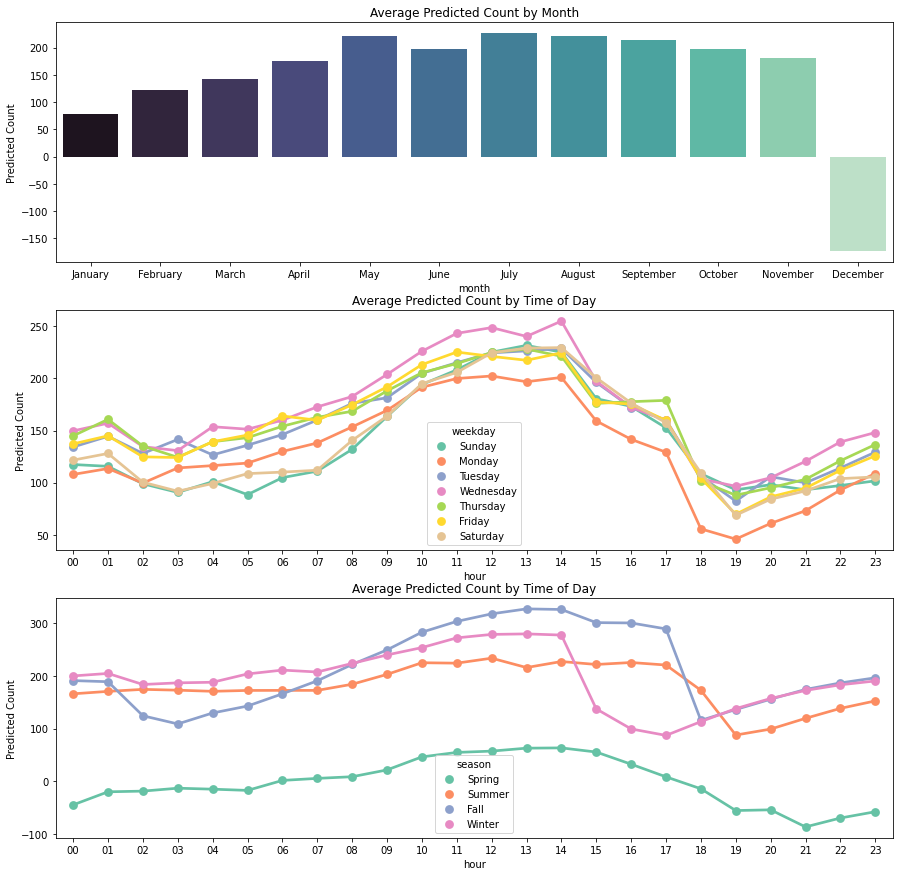

<Figure size 1080x576 with 0 Axes>

In [74]:
fig,ax = plt.subplots(3, figsize=(15,15))

sort_order = ["January","February","March","April","May","June","July","August","September","October","November","December"]
data = quadratic_data.groupby('month')['Predicted Count'].mean().reset_index()
sns.barplot(data=data , x='month' , y='Predicted Count', ax=ax[0] , order=sort_order , palette='mako')
ax[0].set_title('Average Predicted Count by Month')

hue_order = ["Sunday","Monday","Tuesday","Wednesday","Thursday","Friday","Saturday"]
data = quadratic_data.groupby(['hour' , 'weekday'])['Predicted Count'].mean().reset_index()
sns.pointplot(data=data , x='hour' , y='Predicted Count' , ax=ax[1] , hue='weekday' , hue_order=hue_order , join=True , palette='Set2')
ax[1].set_title('Average Predicted Count by Time of Day')

hue_order = ["Sunday","Monday","Tuesday","Wednesday","Thursday","Friday","Saturday"]
plt.figure(figsize=(15,8))
data = quadratic_data.groupby(['hour' , 'season'])['Predicted Count'].mean().reset_index()
sns.pointplot(data=data , x='hour' , y='Predicted Count' , ax=ax[2] , hue='season' , hue_order=['Spring' , 'Summer' , 'Fall' , 'Winter'] , join=True , palette='Set2')
ax[2].set_title('Average Predicted Count by Time of Day')


plt.show()

<div class="alert alert-block alert-danger">
    <h3 align="center">New Data - K Nearest Neighbour Regression Prediction</h3>
</div>

<div class="alert alert-block alert-warning">
    <ul>
        <li>Rental distribuation is normal</li>
        <li>Model didn't predicted negative values which is a good sign!</li>
        <li>Average rental count across time of day per weekday and season and across month closely resemble actual data</li>
    </ul>
</div>

In [75]:
y_data_pred = knn.predict(x_data_test)
predicted = pd.DataFrame(y_data_pred.reshape(-1,1) , columns=['Predicted Count'])
knn_data = pd.concat([data_test , predicted] , axis=1)
knn_data.sample()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,date,hour,weekday,month,Predicted Count
188,2011-01-29 01:00:00,Spring,0,0,Clear + Few clouds + Partly cloudy + Partly c...,9.02,11.365,64,12.998,2011-01-29,01,Saturday,January,22.0


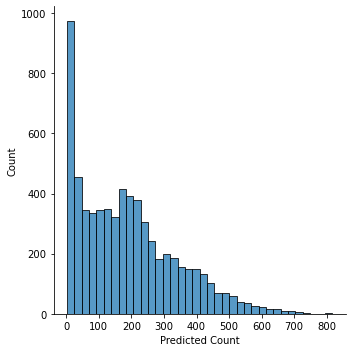

In [76]:
sns.displot(data=knn_data , x='Predicted Count')

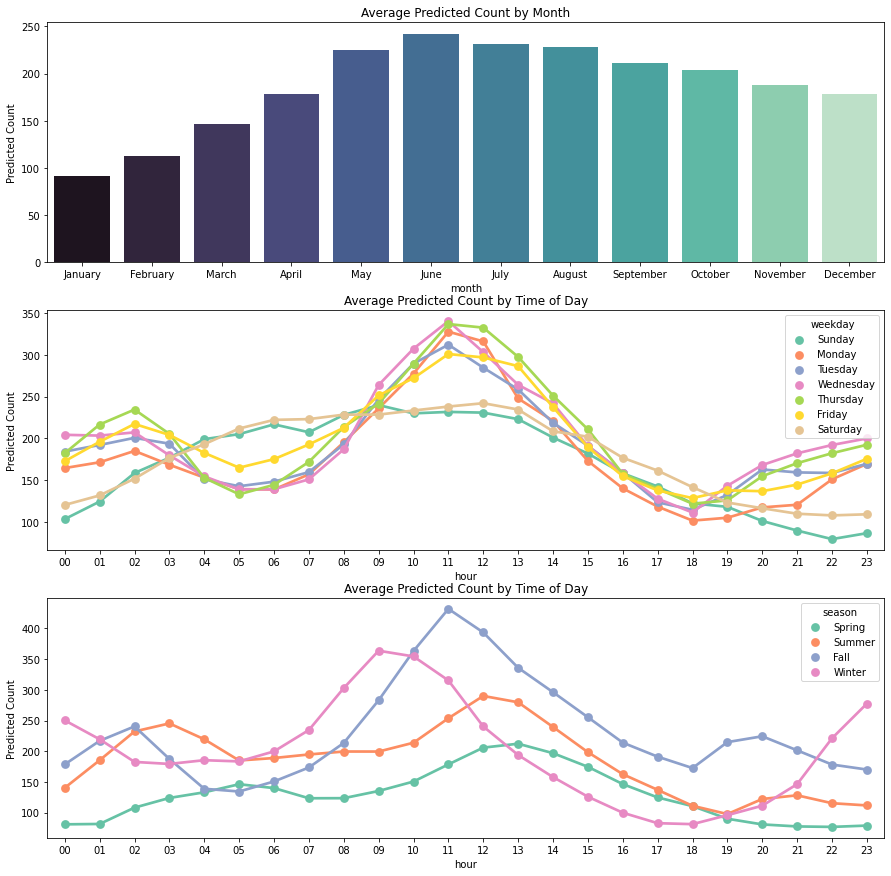

<Figure size 1080x576 with 0 Axes>

In [77]:
fig,ax = plt.subplots(3, figsize=(15,15))

sort_order = ["January","February","March","April","May","June","July","August","September","October","November","December"]
data = knn_data.groupby('month')['Predicted Count'].mean().reset_index()
sns.barplot(data=data , x='month' , y='Predicted Count', ax=ax[0] , order=sort_order , palette='mako')
ax[0].set_title('Average Predicted Count by Month')

hue_order = ["Sunday","Monday","Tuesday","Wednesday","Thursday","Friday","Saturday"]
data = knn_data.groupby(['hour' , 'weekday'])['Predicted Count'].mean().reset_index()
sns.pointplot(data=data , x='hour' , y='Predicted Count' , ax=ax[1] , hue='weekday' , hue_order=hue_order , join=True , palette='Set2')
ax[1].set_title('Average Predicted Count by Time of Day')

hue_order = ["Sunday","Monday","Tuesday","Wednesday","Thursday","Friday","Saturday"]
plt.figure(figsize=(15,8))
data = knn_data.groupby(['hour' , 'season'])['Predicted Count'].mean().reset_index()
sns.pointplot(data=data , x='hour' , y='Predicted Count' , ax=ax[2] , hue='season' , hue_order=['Spring' , 'Summer' , 'Fall' , 'Winter'] , join=True , palette='Set2')
ax[2].set_title('Average Predicted Count by Time of Day')


plt.show()

<div class="alert alert-block alert-danger">
    <h3 align="center">New Data - Decision Tree Regression Prediction</h3>
</div>

<div class="alert alert-block alert-warning">
    <ul>
        <li>Rental distribuation is normal</li>
        <li>Model didn't predicted negative values which is a good sign!</li>
        <li>Average rental count across time of day per weekday and season and across month closely resemble actual data</li>
    </ul>
</div>

In [78]:
y_data_pred = dt_regressor.predict(x_data_test)
predicted = pd.DataFrame(y_data_pred.reshape(-1,1) , columns=['Predicted Count'])
dt_data = pd.concat([data_test , predicted] , axis=1)
dt_data.sample()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,date,hour,weekday,month,Predicted Count
3772,2012-03-21 00:00:00,Summer,0,1,Clear + Few clouds + Partly cloudy + Partly c...,21.32,25.0,88,0.0,2012-03-21,00,Wednesday,March,2.0


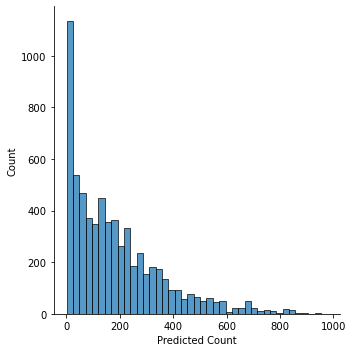

In [79]:
sns.displot(data=dt_data , x='Predicted Count')

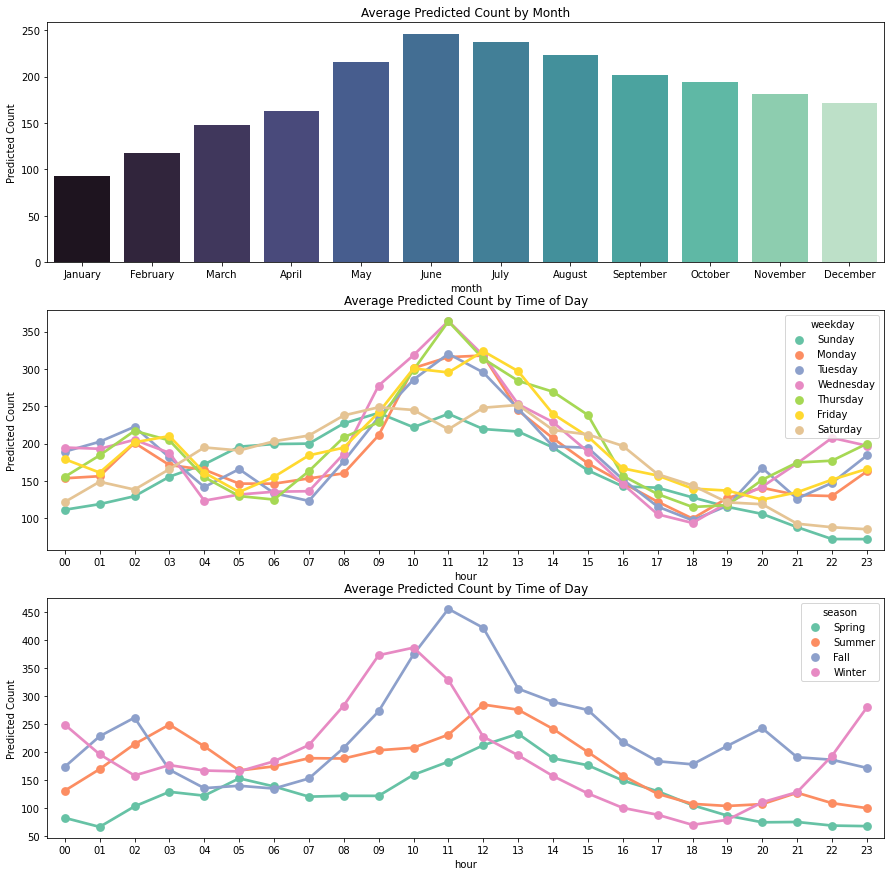

<Figure size 1080x576 with 0 Axes>

In [80]:
fig,ax = plt.subplots(3, figsize=(15,15))

sort_order = ["January","February","March","April","May","June","July","August","September","October","November","December"]
data = dt_data.groupby('month')['Predicted Count'].mean().reset_index()
sns.barplot(data=data , x='month' , y='Predicted Count', ax=ax[0] , order=sort_order , palette='mako')
ax[0].set_title('Average Predicted Count by Month')

hue_order = ["Sunday","Monday","Tuesday","Wednesday","Thursday","Friday","Saturday"]
data = dt_data.groupby(['hour' , 'weekday'])['Predicted Count'].mean().reset_index()
sns.pointplot(data=data , x='hour' , y='Predicted Count' , ax=ax[1] , hue='weekday' , hue_order=hue_order , join=True , palette='Set2')
ax[1].set_title('Average Predicted Count by Time of Day')

hue_order = ["Sunday","Monday","Tuesday","Wednesday","Thursday","Friday","Saturday"]
plt.figure(figsize=(15,8))
data = dt_data.groupby(['hour' , 'season'])['Predicted Count'].mean().reset_index()
sns.pointplot(data=data , x='hour' , y='Predicted Count' , ax=ax[2] , hue='season' , hue_order=['Spring' , 'Summer' , 'Fall' , 'Winter'] , join=True , palette='Set2')
ax[2].set_title('Average Predicted Count by Time of Day')


plt.show()

<div class="alert alert-block alert-danger">
    <h3 align="center">New Data - Random Forest Regression Prediction</h3>
</div>

<div class="alert alert-block alert-warning">
    <ul>
        <li>Rental distribuation is normal</li>
        <li>Model didn't predicted negative values which is a good sign!</li>
        <li>Average rental count across time of day per weekday and season and across month closely resemble actual data</li>
    </ul>
</div>

In [81]:
y_data_pred = rf_regressor.predict(x_data_test)
predicted = pd.DataFrame(y_data_pred.reshape(-1,1) , columns=['Predicted Count'])
rf_data = pd.concat([data_test , predicted] , axis=1)
rf_data.sample()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,date,hour,weekday,month,Predicted Count
3661,2012-02-26 08:00:00,Spring,0,0,Clear + Few clouds + Partly cloudy + Partly c...,8.2,9.85,51,16.9979,2012-02-26,08,Sunday,February,129.305


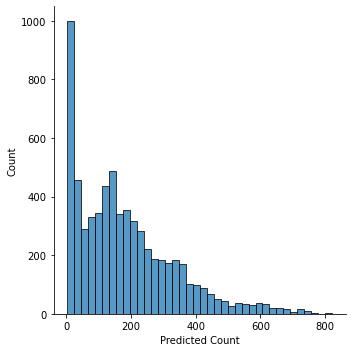

In [82]:
sns.displot(data=rf_data , x='Predicted Count')

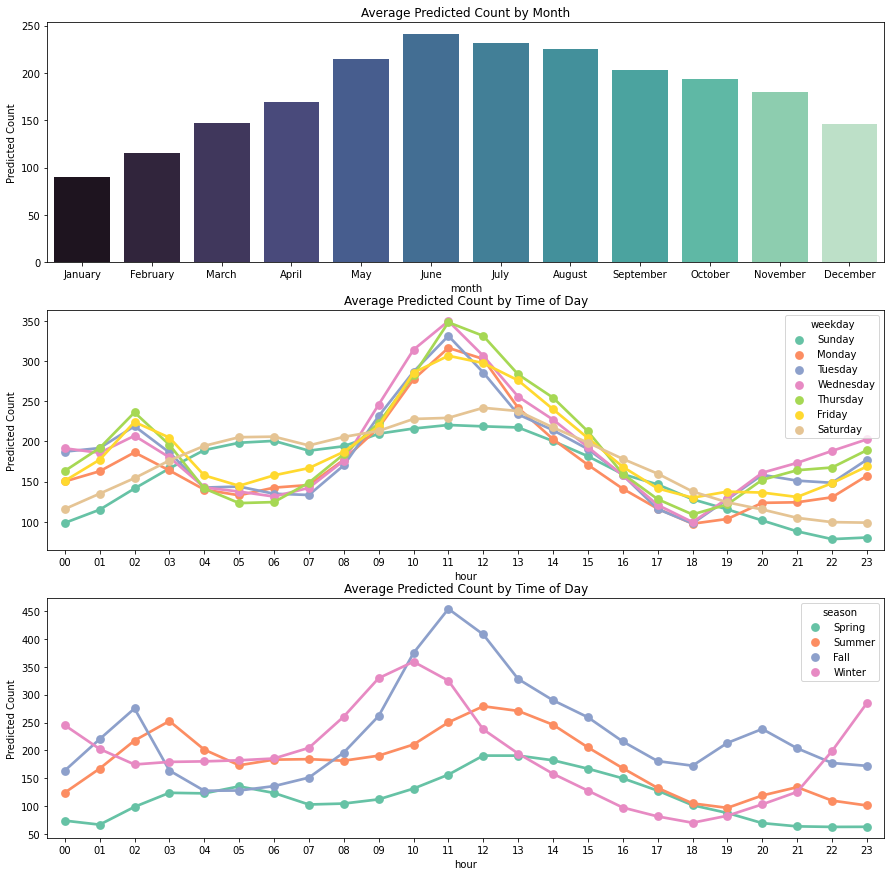

<Figure size 1080x576 with 0 Axes>

In [83]:
fig,ax = plt.subplots(3, figsize=(15,15))

sort_order = ["January","February","March","April","May","June","July","August","September","October","November","December"]
data = rf_data.groupby('month')['Predicted Count'].mean().reset_index()
sns.barplot(data=data , x='month' , y='Predicted Count', ax=ax[0] , order=sort_order , palette='mako')
ax[0].set_title('Average Predicted Count by Month')

hue_order = ["Sunday","Monday","Tuesday","Wednesday","Thursday","Friday","Saturday"]
data = rf_data.groupby(['hour' , 'weekday'])['Predicted Count'].mean().reset_index()
sns.pointplot(data=data , x='hour' , y='Predicted Count' , ax=ax[1] , hue='weekday' , hue_order=hue_order , join=True , palette='Set2')
ax[1].set_title('Average Predicted Count by Time of Day')

hue_order = ["Sunday","Monday","Tuesday","Wednesday","Thursday","Friday","Saturday"]
plt.figure(figsize=(15,8))
data = rf_data.groupby(['hour' , 'season'])['Predicted Count'].mean().reset_index()
sns.pointplot(data=data , x='hour' , y='Predicted Count' , ax=ax[2] , hue='season' , hue_order=['Spring' , 'Summer' , 'Fall' , 'Winter'] , join=True , palette='Set2')
ax[2].set_title('Average Predicted Count by Time of Day')


plt.show()

<div class="alert alert-block alert-danger">
    <h3 align="center">New Data - XGBoost Regression Prediction</h3>
</div>

<div class="alert alert-block alert-warning">
    <ul>
        <li>Rental distribuation is normal</li>
        <li>Model didn't predicted negative values which is a good sign!</li>
        <li>Average rental count across time of day per weekday and season and across month closely resemble actual data</li>
    </ul>
</div>

In [84]:
y_data_pred = xgb_reg.predict(x_data_test)
predicted = pd.DataFrame(y_data_pred.reshape(-1,1) , columns=['Predicted Count'])
xgb_data = pd.concat([data_test , predicted] , axis=1)
xgb_data.sample()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,date,hour,weekday,month,Predicted Count
666,2011-03-28 18:00:00,Summer,0,1,Clear + Few clouds + Partly cloudy + Partly c...,13.12,15.15,21,19.0012,2011-03-28,18,Monday,March,36.115063


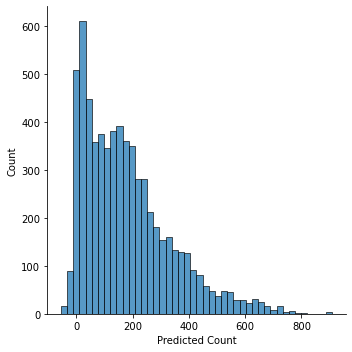

In [85]:
sns.displot(data=xgb_data , x='Predicted Count')

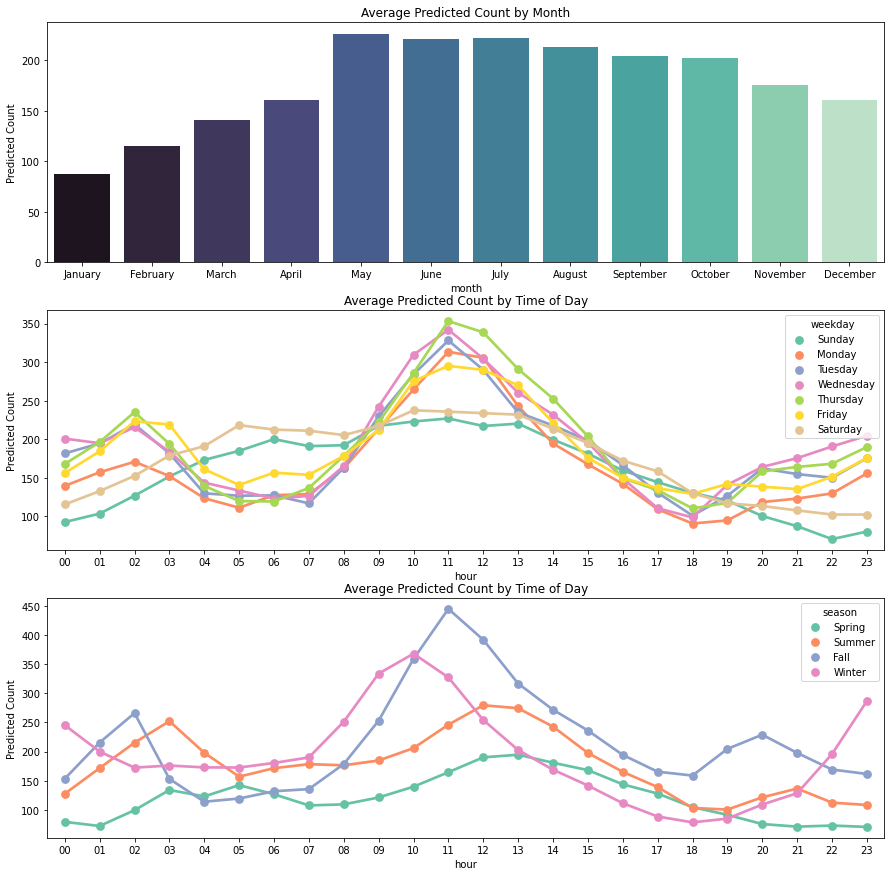

<Figure size 1080x576 with 0 Axes>

In [86]:
fig,ax = plt.subplots(3, figsize=(15,15))

sort_order = ["January","February","March","April","May","June","July","August","September","October","November","December"]
data = xgb_data.groupby('month')['Predicted Count'].mean().reset_index()
sns.barplot(data=data , x='month' , y='Predicted Count', ax=ax[0] , order=sort_order , palette='mako')
ax[0].set_title('Average Predicted Count by Month')

hue_order = ["Sunday","Monday","Tuesday","Wednesday","Thursday","Friday","Saturday"]
data = xgb_data.groupby(['hour' , 'weekday'])['Predicted Count'].mean().reset_index()
sns.pointplot(data=data , x='hour' , y='Predicted Count' , ax=ax[1] , hue='weekday' , hue_order=hue_order , join=True , palette='Set2')
ax[1].set_title('Average Predicted Count by Time of Day')

hue_order = ["Sunday","Monday","Tuesday","Wednesday","Thursday","Friday","Saturday"]
plt.figure(figsize=(15,8))
data = xgb_data.groupby(['hour' , 'season'])['Predicted Count'].mean().reset_index()
sns.pointplot(data=data , x='hour' , y='Predicted Count' , ax=ax[2] , hue='season' , hue_order=['Spring' , 'Summer' , 'Fall' , 'Winter'] , join=True , palette='Set2')
ax[2].set_title('Average Predicted Count by Time of Day')


plt.show()

<div class="alert alert-block alert-danger">
    <h3 align="center">New Data - Support Vector Regression Prediction</h3>
</div>

<div class="alert alert-block alert-warning">
    <ul>
        <li>Rental distribuation isn't normal and has an even distribuation</li>
        <li>Model didn't predicted many negative values which is a good sign!</li>
        <li>Average rental count across time of day per weekday and season and across month isn't normal</li>
    </ul>
</div>

In [87]:
y_data_pred = svr_reg.predict(x_data_test)
predicted = pd.DataFrame(y_data_pred.reshape(-1,1) , columns=['Predicted Count'])
svr_data = pd.concat([data_test , predicted] , axis=1)
svr_data.sample()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,date,hour,weekday,month,Predicted Count
1247,2011-05-29 23:00:00,Summer,0,0,Clear + Few clouds + Partly cloudy + Partly c...,27.06,29.545,89,11.0014,2011-05-29,23,Sunday,May,219.010859


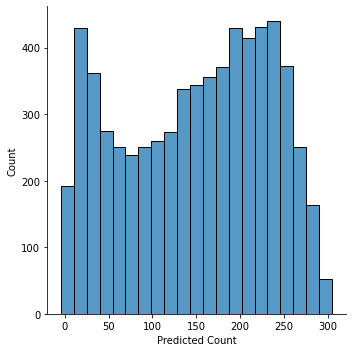

In [88]:
sns.displot(data=svr_data , x='Predicted Count')

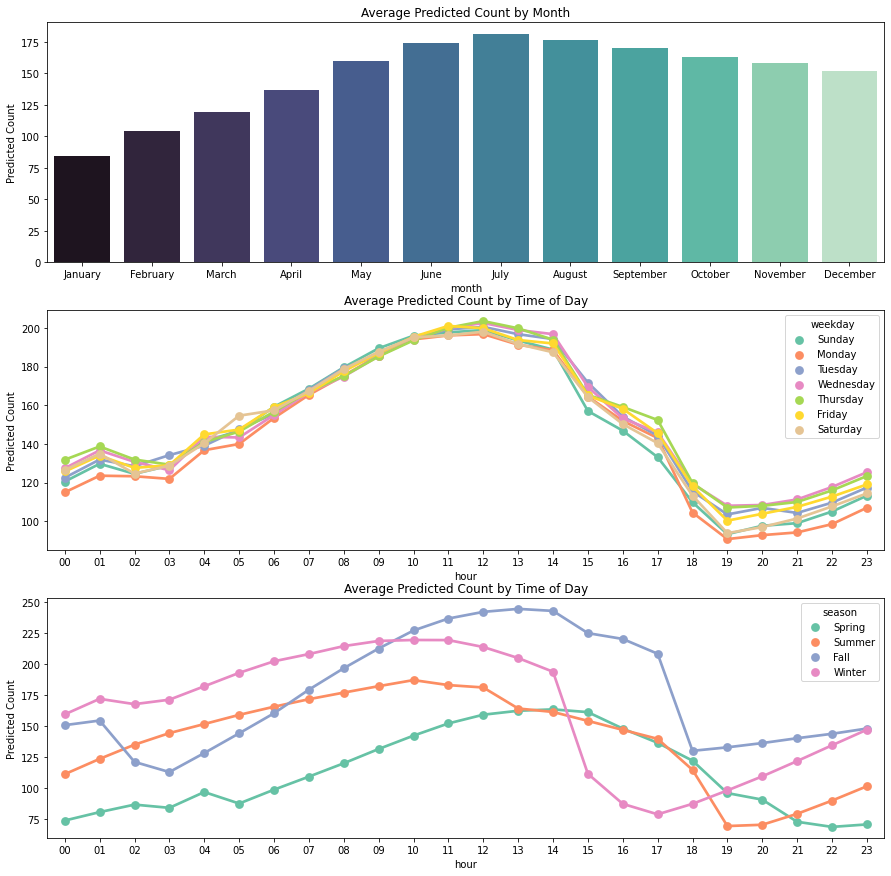

<Figure size 1080x576 with 0 Axes>

In [89]:
fig,ax = plt.subplots(3, figsize=(15,15))

sort_order = ["January","February","March","April","May","June","July","August","September","October","November","December"]
data = svr_data.groupby('month')['Predicted Count'].mean().reset_index()
sns.barplot(data=data , x='month' , y='Predicted Count', ax=ax[0] , order=sort_order , palette='mako')
ax[0].set_title('Average Predicted Count by Month')

hue_order = ["Sunday","Monday","Tuesday","Wednesday","Thursday","Friday","Saturday"]
data = svr_data.groupby(['hour' , 'weekday'])['Predicted Count'].mean().reset_index()
sns.pointplot(data=data , x='hour' , y='Predicted Count' , ax=ax[1] , hue='weekday' , hue_order=hue_order , join=True , palette='Set2')
ax[1].set_title('Average Predicted Count by Time of Day')

hue_order = ["Sunday","Monday","Tuesday","Wednesday","Thursday","Friday","Saturday"]
plt.figure(figsize=(15,8))
data = svr_data.groupby(['hour' , 'season'])['Predicted Count'].mean().reset_index()
sns.pointplot(data=data , x='hour' , y='Predicted Count' , ax=ax[2] , hue='season' , hue_order=['Spring' , 'Summer' , 'Fall' , 'Winter'] , join=True , palette='Set2')
ax[2].set_title('Average Predicted Count by Time of Day')


plt.show()